In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
ocpp = pd.read_csv('data/ocpp.csv')
sessions = pd.read_csv('data/sessions.csv')

In [7]:
sessions['charge_date'] = pd.to_datetime(sessions['charge_date'])
charger_data = sessions[(sessions['charger_id'] == '37A80B4D') & (sessions['charge_date'] == '2023-01-23')]
print(charger_data)

       charge_date charger_id  connector_id  sessions  failed_sessions
1       2023-01-23   37A80B4D             3         3                3
461     2023-01-23   37A80B4D             2        10                0
432971  2023-01-23   37A80B4D             1         1                0


In [8]:
ocpp['charge_date'] = pd.to_datetime(ocpp['error_at'])
ocpp_data = ocpp[(ocpp['charger_id'] == '37A80B4D') & (ocpp['error_at'] == '2023-01-23')]
print(ocpp_data)

Empty DataFrame
Columns: [supplier, charger_id, connector_id, error_code, vendor_error_code, total_error_notifications, error_at, charge_date]
Index: []


In [9]:
sessions['target'] = (sessions['failed_sessions'] / sessions['sessions']) + (1 / (1 + sessions['sessions']))

sessions['target'] = sessions['target'].clip(0, 1)

print(sessions[['charge_date', 'charger_id', 'connector_id', 'sessions', 'failed_sessions', 'target']].head())

  charge_date charger_id  connector_id  sessions  failed_sessions    target
0  2023-01-16   34406128             5         4                0  0.200000
1  2023-01-23   37A80B4D             3         3                3  1.000000
2  2023-01-18   AA92D18E             2         2                0  0.333333
3  2023-01-28   FF15DC0B             3         2                0  0.333333
4  2023-01-19   06B95C56             2         1                0  0.500000


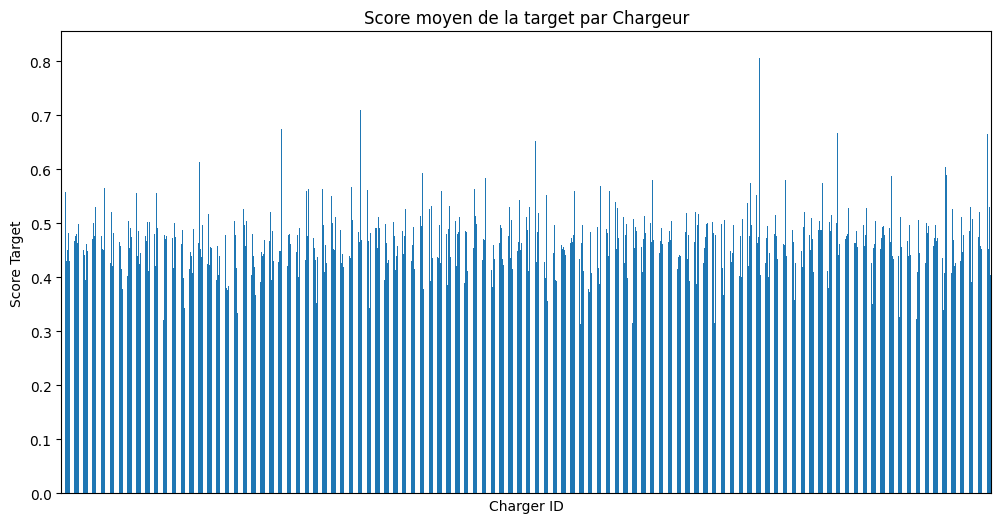

In [10]:
# Visualisation de la distribution de la target pour chaque chargeur
plt.figure(figsize=(12, 6))
sessions.groupby('charger_id')['target'].mean().plot(kind='bar')
plt.title('Score moyen de la target par Chargeur')
plt.xlabel('Charger ID')
plt.ylabel('Score Target')
plt.xticks([])
plt.show()

In [11]:
# Fonction pour calculer la target
def metric1(chargeur_id, connector_id, sessions):
    filtered_sessions = sessions[(sessions['charger_id'] == chargeur_id) & (sessions['connector_id'] == connector_id)]
    filtered_sessions['target'] = (filtered_sessions['failed_sessions'] / filtered_sessions['sessions']) + (1 / (1 + filtered_sessions['sessions']))
    max = np.max(filtered_sessions['target'])
    filtered_sessions['target']=filtered_sessions['target']/max
    return filtered_sessions

def metric2(chargeur_id, connector_id, sessions):
    filtered_sessions = sessions[(sessions['charger_id'] == chargeur_id) & (sessions['connector_id'] == connector_id)]
    failure_rate=(filtered_sessions['failed_sessions'] / filtered_sessions['sessions'])
    filtered_sessions['target'] =-np.log(1-failure_rate)*np.sqrt(filtered_sessions['sessions'])
    max = np.max(filtered_sessions['target'])
    filtered_sessions['target']=filtered_sessions['target']/max
    return filtered_sessions



/var/folders/sr/46v6whpx60ddty1hz2kklbhc0000gn/T/ipykernel_13379/2387183081.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sessions['target'] = (filtered_sessions['failed_sessions'] / filtered_sessions['sessions']) + (1 / (1 + filtered_sessions['sessions']))
/var/folders/sr/46v6whpx60ddty1hz2kklbhc0000gn/T/ipykernel_13379/2387183081.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sessions['target']=filtered_sessions['target']/max


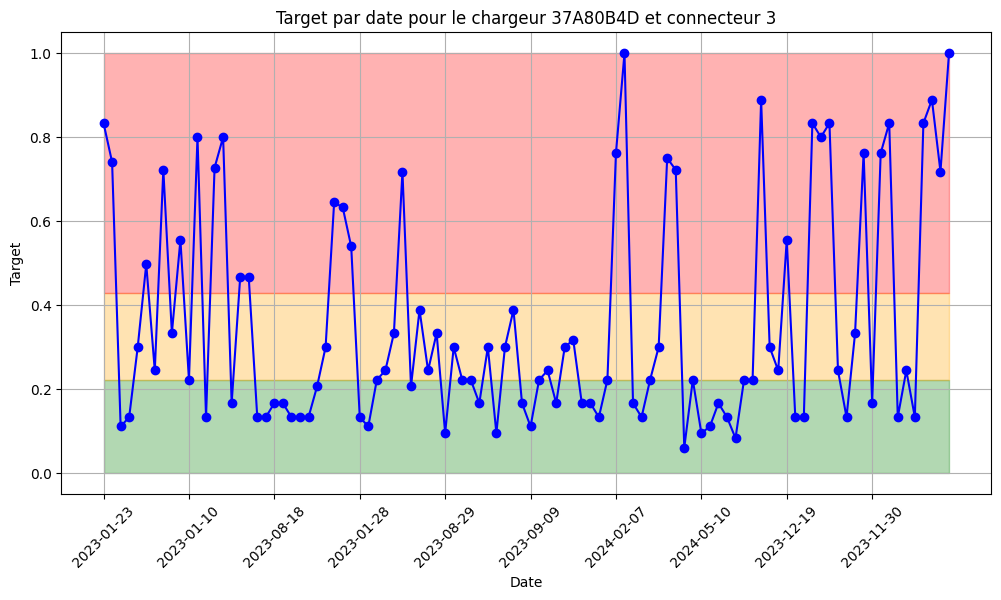

In [14]:
sessions = pd.read_csv('data/sessions.csv')
ocpp = pd.read_csv('data/ocpp.csv')
chargeur_id = '37A80B4D'
connector_id = 3

filtered_sessions = metric1(chargeur_id, connector_id, sessions)


q1 = filtered_sessions['target'].quantile(0.40) 
q2 = filtered_sessions['target'].quantile(0.65)
#q3 = filtered_sessions['target'].quantile(0.75)


plt.figure(figsize=(12, 6))

plt.fill_between(filtered_sessions['charge_date'][:100], 0, q1, color='green', alpha=0.3, label="Bonne zone (0-0.2)")
plt.fill_between(filtered_sessions['charge_date'][:100], q1, q2, color='orange', alpha=0.3, label="Zone moyenne (0.2-0.6)")
plt.fill_between(filtered_sessions['charge_date'][:100], q2, 1, color='red', alpha=0.3, label="Mauvaise zone (0.6-1)")

plt.plot(filtered_sessions['charge_date'][:100], filtered_sessions['target'][:100], marker='o', linestyle='-', color='b')
plt.title(f"Target par date pour le chargeur {chargeur_id} et connecteur {connector_id}")
plt.xlabel('Date')
plt.ylabel('Target')

plt.xticks(filtered_sessions['charge_date'][:100:10], rotation=45)
plt.grid(True)
plt.show()